The file `ez-target.txt` contains 20 epochs of 0.05 percent of the training data evaluated against training data, to prove the mode learns something.

[Plot task-wise loss](#Plot-task-wise-loss)

[Plot metrics](#Plot-metrics)

[BertHead](#BertHead)

[FgsaLSTM](#FgsaLSTM)

[Dice LSTM](#Dice-LSTM)

[MIULoss](#MIULoss)

[Frostbert](#Frostbert)

[7 Layers](#7-Layers)

[Confusion matrix](#Confusion-matrix)

[Study taskwise loss](#Study-taskwise-loss)

[IMN](#IMN)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('ez-target.txt') as f:
    raw = f.readlines()

In [3]:
def preprocess(data):
    lines = [
        row.split(', ')[:-1]
        for row in data
    ]
    
    cleaned = [ 
        [ float(ele) for ele in row ]
        for row in lines
    ]
    
    return cleaned   

<AxesSubplot:title={'center':'F1 scores vs epoch for each label'}>

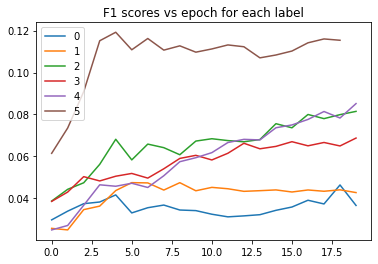

In [4]:
data = preprocess(raw)
df = pd.DataFrame(data)
df.plot(title="F1 scores vs epoch for each label")

# Plot losses functions

In [5]:
import pandas as pd

### DEPRECATED _____________________________________
This is for the old logging format.

In [6]:
def parse_batchwise_loss(data):
    """Assume data is f.readlines() of a log file."""
    epochs = {}
    for line in data:
        if "Epoch:" in line:
            tail = line.split('Epoch:')[-1]
            tail = tail.split('Batch:')
            epoch = int(tail[0].strip())
            tail = tail[-1].split('Loss:')
            batch = int(tail[0].strip())
            loss = float(tail[-1].split(' ')[0].strip())
            if epoch in epochs:
                epochs[epoch][batch] = loss
            else:
                epochs[epoch] = {batch: loss}
    return epochs

,0,13,26,39,52
0,1.606532,1.535955,1.462392,1.553157,1.426108
1,1.502192,1.417256,1.345471,1.495587,1.382338
2,1.460871,1.372689,1.293997,1.473846,1.338020
3,1.426862,1.309798,1.264082,1.451201,1.310963
4,1.379389,1.301479,1.222378,1.403198,1.271874
5,1.338985,1.263005,1.170460,1.375762,1.246793
6,1.310531,1.252072,1.143852,1.340909,1.212692
7,1.273219,1.205023,1.098382,1.317168,1.169170
8,1.211803,1.167133,1.078278,1.278615,1.140334
9,1.166646,1.130845,1.001915,1.229370,1.097433


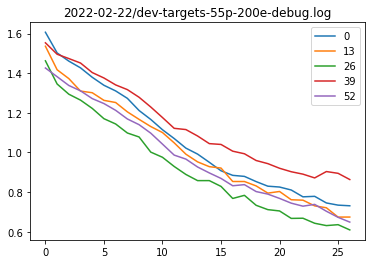

In [7]:
def show_batchwise_loss(name):
    with open(name) as f:
        data = f.readlines()

    loss = parse_batchwise_loss(data)
    
    df = pd.DataFrame.from_dict(loss, orient="index")
    df.plot(title=name)
    
    return df

show_batchwise_loss("2022-02-22/dev-targets-55p-200e-debug.log")

### ----------------------------------------------------------------------------------

# Plot task-wise loss
Below is correct parsing for logging after `BertHead` was made:

In [8]:
d = {'a':1, 'b':2}
d.pop('a')
list(d)

['b']

In [9]:
def parse_taskwise_loss(data, get_epochs=True):
    """Assume data is f.readlines() of a log file."""
    task_loss = {
        "expression": [],
        "holder": [],
        "polarity": [],
        "target": [],
        "total": [],
    }
    
    epochs = [0]
    prev_batches = -1
    
    for line in data:
        # goes first to get correct len of task_loss item for current line
        if get_epochs:
            if "Epoch:" in line and "Batch:" in line:
                batch = int(line.split("Batch:")[-1].split('(')[0].strip())
                if prev_batches < batch:
                    prev_batches = batch
                else:
                    longest = max([len(task_loss[i]) for i in task_loss])
                    epochs.append(longest)
                    prev_batches = -1
            
        if "loss" in line:
            task = line.split("INFO] ")[-1].split('loss:')[0].strip().lower()
            loss = float(line.split('loss:')[-1].split(' ')[0].strip())
            task_loss[task].append(loss)
            
    for task in list(task_loss):
        if task_loss[task] == []:
            task_loss.pop(task)
        
    return task_loss, epochs

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
expression,1.055230,1.038382,1.054603,0.954892,0.918813,0.997449,0.938732,0.827586,0.923229,0.914004,...,0.602727,0.813351,0.775190,0.474645,0.756578,0.778110,0.635462,0.408311,0.829811,0.711488
holder,1.043562,0.898947,0.860491,0.744109,0.580502,0.521941,0.493008,0.387358,0.353600,0.302860,...,0.031768,0.055323,0.026960,0.043701,0.058958,0.071995,0.024376,0.025555,0.087941,0.057750
polarity,0.908942,0.891368,0.810474,0.742193,0.627278,0.620189,0.589874,0.568739,0.500702,0.542310,...,0.357599,0.288619,0.412414,0.185228,0.398796,0.328187,0.235374,0.233232,0.388879,0.323827
target,1.385927,1.277809,1.155163,0.999810,0.844243,0.835274,0.710908,0.662210,0.588854,0.595373,...,0.365565,0.303949,0.419782,0.190870,0.420336,0.343494,0.232146,0.243848,0.405786,0.331517


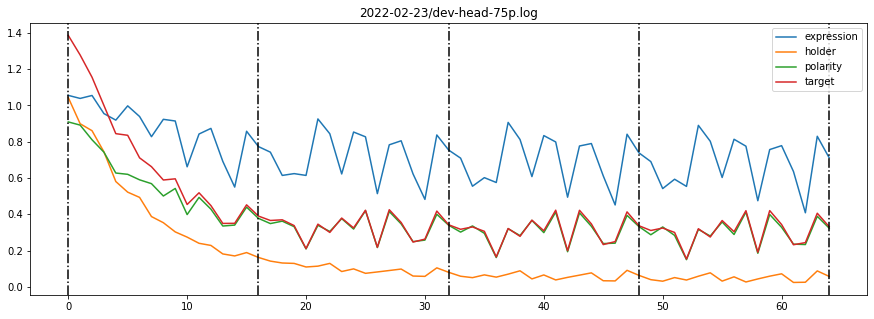

In [10]:
def show_taskwise_loss(name, get_epochs=True, title=None):
    def show_epochs(epochs):
        for x in epochs:
            plt.axvline(x, c="k", ls="-.")
        

    with open(name) as f:
        data = f.readlines()

    loss, epochs = parse_taskwise_loss(data, get_epochs)

    df = pd.DataFrame.from_dict(loss)
    plt = df.plot(title=title if title else name, figsize=(15,5))
    show_epochs(epochs) if get_epochs else None
    
    return df.T  # show table horizontally

show_taskwise_loss("2022-02-23/dev-head-75p.log")

# Plot metric

In [11]:
def parse_metrics(data):
    """Assume data is f.readlines() of a log file."""
    scores = {
        "absa": [],
        "easy": [],
        "hard": [],
        "binary": [],
        "proportional": [],
        "span": [],
        "macro": [],
    }
    
    for line in data:
            
        if " overall: " in line:
            metric = line.split("INFO] ")[-1].split("overall:")[0].strip()
            if "(RACL)" in metric:
                metric = metric.split("(RACL)")[-1].strip()
            loss = float(line.split('overall: ')[-1].split(' (')[0].strip())
            scores[metric.lower()].append(loss)
            
    for metric in list(scores):
        if scores[metric] == []:
            scores.pop(metric)
        
    return scores

In [12]:
def show_data(data, title=None):
    df = pd.DataFrame.from_dict(data)
    df.plot(title=title, figsize=(15,5))
    return df

,0,1,2,3
easy,0.591195,0.591195,0.591195,0.591195
hard,0.000000,0.000000,0.000000,0.000000


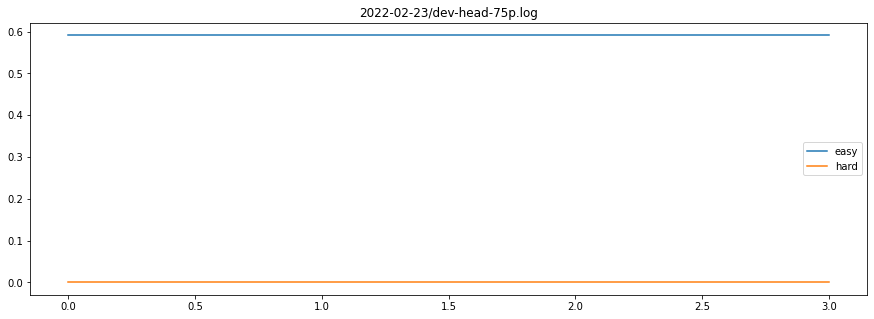

In [13]:
def show_metrics(name, title=None):

    with open(name) as f:
        data = f.readlines()

    scores = parse_metrics(data)
    df = show_data(scores, title=title if title else name)
    
    return df.T  # show table horizontally

show_metrics("2022-02-23/dev-head-75p.log")

# BertHead

Bert embeddings w/ individual linear classifiers per subtask.

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
expression,1.055230,1.038382,1.054603,0.954892,0.918813,0.997449,0.938732,0.827586,0.923229,0.914004,...,0.602727,0.813351,0.775190,0.474645,0.756578,0.778110,0.635462,0.408311,0.829811,0.711488
holder,1.043562,0.898947,0.860491,0.744109,0.580502,0.521941,0.493008,0.387358,0.353600,0.302860,...,0.031768,0.055323,0.026960,0.043701,0.058958,0.071995,0.024376,0.025555,0.087941,0.057750
polarity,0.908942,0.891368,0.810474,0.742193,0.627278,0.620189,0.589874,0.568739,0.500702,0.542310,...,0.357599,0.288619,0.412414,0.185228,0.398796,0.328187,0.235374,0.233232,0.388879,0.323827
target,1.385927,1.277809,1.155163,0.999810,0.844243,0.835274,0.710908,0.662210,0.588854,0.595373,...,0.365565,0.303949,0.419782,0.190870,0.420336,0.343494,0.232146,0.243848,0.405786,0.331517


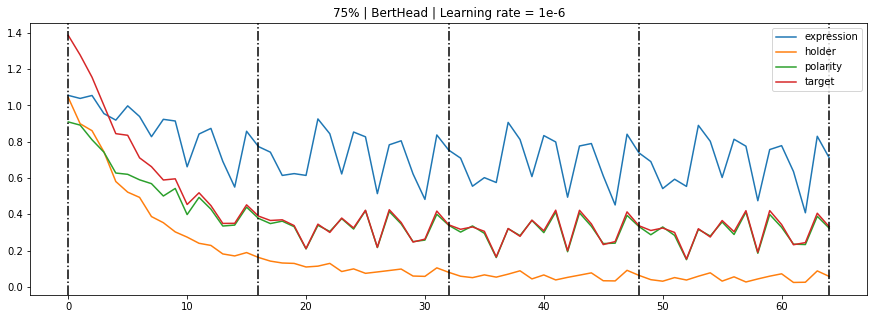

In [14]:
show_taskwise_loss("2022-02-23/dev-head-75p.log", title="75% | BertHead | Learning rate = 1e-6")

# BertHead

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
expression,1.172830,1.164282,1.150871,1.110666,0.981092,0.968930,1.035424,0.979514,0.828342,0.947124,...,0.583394,0.801098,0.740066,0.428650,0.712561,0.657103,0.493225,0.576326,0.490835,0.825553
holder,1.214497,1.078318,1.012003,0.919445,0.766234,0.672357,0.607840,0.558143,0.471735,0.427525,...,0.030451,0.051909,0.024075,0.043877,0.058012,0.033126,0.025670,0.047570,0.033156,0.055972
polarity,0.967286,1.051198,1.006343,0.922059,0.824991,0.702602,0.707865,0.644063,0.613823,0.557393,...,0.328667,0.265386,0.386960,0.157124,0.310158,0.250834,0.304709,0.251124,0.118631,0.284332
target,1.203057,1.404406,1.247717,1.062433,1.039562,0.848111,0.807363,0.736502,0.687671,0.590188,...,0.337841,0.280466,0.392768,0.163855,0.316296,0.266488,0.300906,0.268534,0.119890,0.281997


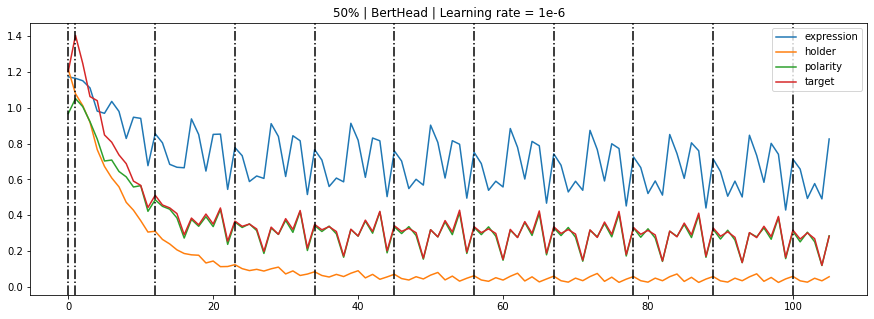

In [15]:
show_taskwise_loss("2022-02-23/dev-head-50p.log", title="50% | BertHead | Learning rate = 1e-6")

# BertHead w/ taskwise learning rate

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
expression,1.101624,1.095494,1.038092,0.971895,0.965129,0.985341,0.934474,0.839798,0.932246,0.898948,...,0.675077,0.578757,0.788154,0.666485,0.404099,0.653011,0.590964,0.454091,0.547437,0.478102
holder,1.016269,0.902144,0.853378,0.720533,0.656800,0.603694,0.507428,0.453653,0.422542,0.361071,...,0.070862,0.028178,0.049942,0.021280,0.041651,0.054140,0.028762,0.021629,0.044122,0.029595
polarity,1.171356,1.031386,1.002641,0.860628,0.804858,0.722539,0.658833,0.629709,0.532628,0.554091,...,0.230380,0.287973,0.223126,0.325405,0.153010,0.251673,0.225766,0.291106,0.220246,0.094724
target,1.342760,1.210711,1.174277,1.033132,1.002386,0.847732,0.800871,0.754011,0.654846,0.654382,...,0.231189,0.292269,0.237439,0.323813,0.164683,0.266410,0.238451,0.286608,0.234482,0.102029


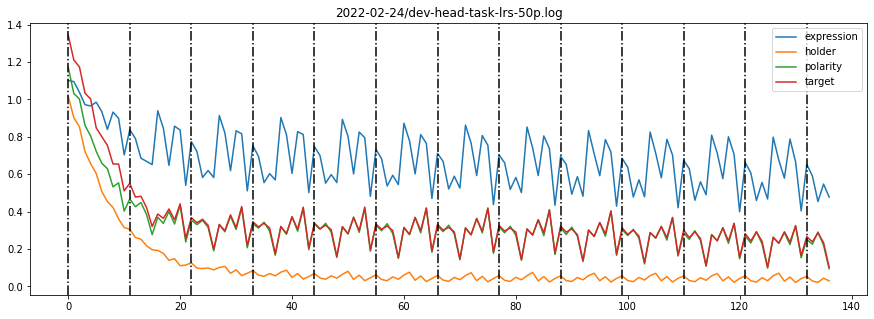

In [16]:
show_taskwise_loss("2022-02-24/dev-head-task-lrs-50p.log")

# FgsaLSTM

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
expression,1.091960,1.088301,1.079463,1.082209,1.076374,1.063764,1.060875,1.058209,1.071621,1.064068,...,0.980568,0.942712,0.956045,0.956286,1.019100,1.003211,0.954646,1.006292,1.002592,0.936100
holder,1.063191,1.047855,1.032763,1.108339,1.090972,1.071578,1.058483,1.036868,1.013077,0.991148,...,0.054442,0.016522,0.055004,0.042541,0.111850,0.151536,0.022593,0.082862,0.023027,0.070371
polarity,1.104245,1.091654,1.084553,1.106156,1.102142,1.093916,1.083334,1.068853,1.061206,1.052634,...,0.737843,0.718910,0.714669,0.690186,0.719347,0.708201,0.721359,0.708950,0.737853,0.676501
target,1.119365,1.109847,1.095348,1.083917,1.066644,1.058839,1.045462,1.038581,1.028746,1.015235,...,0.710947,0.688011,0.687747,0.658256,0.691227,0.677237,0.694153,0.682225,0.712972,0.646300


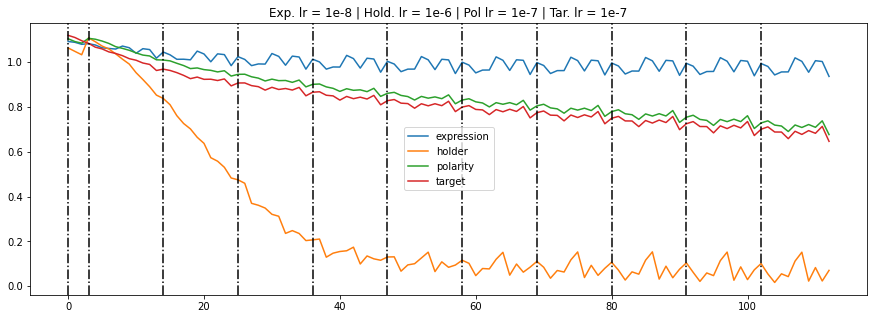

In [17]:
show_taskwise_loss("2022-02-24/dev-lstm-50p-debug.log", title="Exp. lr = 1e-8 | Hold. lr = 1e-6 | Pol lr = 1e-7 | Tar. lr = 1e-7")

Wait, why did we jsut abandon this here? These results aren't good enough yet... 

# Dice LSTM


,0,1,2,3,4,5,6,7
expression,0.698737,0.724138,0.668329,0.741789,0.666980,0.705790,0.691343,0.782407
holder,0.983234,0.997472,1.000000,0.992308,0.986191,0.997241,1.000000,0.992707
polarity,0.869814,0.925801,0.901207,0.914100,0.879552,0.928094,0.900073,0.916135
target,0.782557,0.810089,0.783607,0.821946,0.781775,0.813056,0.781457,0.829268


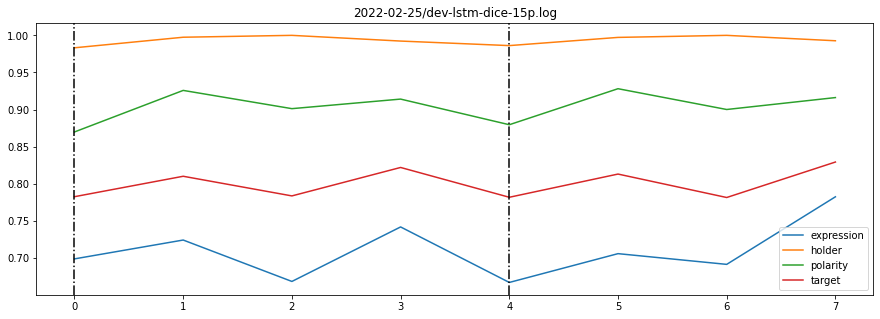

In [18]:
show_taskwise_loss("2022-02-25/dev-lstm-dice-15p.log")

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
expression,0.442897,0.475000,0.605523,0.581288,0.579592,0.371495,0.391655,0.592068,0.406102,0.398529,...,0.434576,0.491296,0.604651,0.587007,0.578301,0.373169,0.397187,0.590811,0.402597,0.400147
holder,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
polarity,0.833333,0.901031,0.881469,0.901973,0.972763,0.857032,0.887097,0.852687,0.890943,0.825875,...,0.842188,0.897106,0.879599,0.905389,0.971182,0.867982,0.890726,0.851064,0.887097,0.821635
target,0.869112,0.882845,0.862069,0.897179,0.972461,0.892895,0.911042,0.848280,0.890559,0.824085,...,0.869112,0.889668,0.855738,0.894006,0.972556,0.893504,0.907776,0.848458,0.890559,0.834794


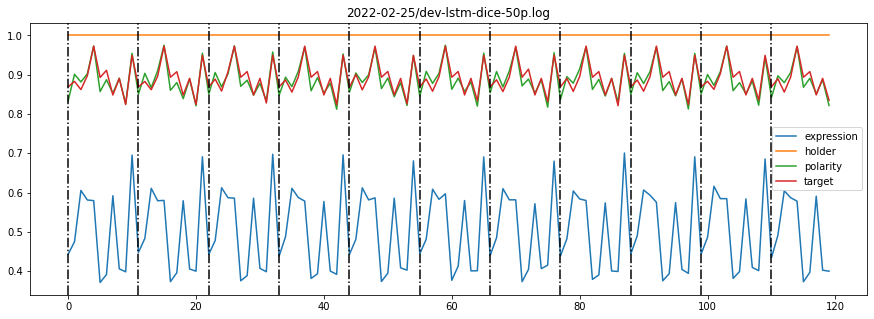

In [19]:
show_taskwise_loss("2022-02-25/dev-lstm-dice-50p.log")

# MIU Loss

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
expression,0.913733,0.910790,0.959031,0.881824,0.924553,0.868010,0.891941,0.911370,0.915298,0.963477,...,0.943141,0.864945,0.889805,0.909145,0.912532,0.962048,0.938717,0.942900,0.863316,0.889142
holder,0.486811,0.297872,0.672718,0.183907,0.435600,0.211890,0.341670,0.392628,0.163729,0.587989,...,-64.152641,-37.006241,-26.600174,-38.275852,-88.067413,-111.831429,-70.038628,-106.778885,-45.492359,-29.753286
polarity,0.567903,0.425879,0.719373,0.335948,0.456871,0.361759,0.427797,0.502237,0.333599,0.655630,...,-15.187073,-4.027818,-5.482147,-3.994802,-4.312157,-3.934379,-4.689721,-17.637808,-4.457306,-5.815386
target,0.689802,0.432600,0.723364,0.343534,0.465225,0.370499,0.437261,0.509987,0.346294,0.665061,...,-13.366331,-3.961656,-5.295437,-3.886530,-4.212841,-3.802147,-4.635039,-16.562155,-4.396125,-5.741620


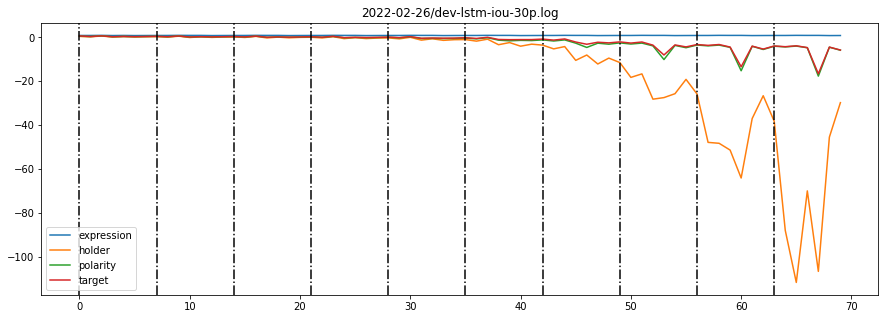

In [20]:
show_taskwise_loss("2022-02-26/dev-lstm-iou-30p.log")

Oh! Negative loss here just means that intersect is greater than union, since you return:

```
intersect = (certainty * expected)  # FIXME in code: overall -> expected
union = expected + predictions - intersect

iou = intersect/union
return 1. - iou
```

If you change how targets are represented in intersect, then you'll get rid of the negatives.

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
expression,0.954794,0.911155,0.872785,0.907196,0.846044,0.813432,0.884068,0.724265,0.771108,0.766115,...,0.759435,0.761685,0.681425,0.763526,0.760968,0.680630,0.764251,0.763508,0.684093,0.760689
holder,0.996827,0.967867,0.931442,0.783731,0.444740,0.696631,0.527539,0.343770,0.651145,0.451352,...,0.523266,0.275334,0.068362,0.492745,0.229718,0.019665,0.465268,0.193902,-0.034039,0.418765
polarity,0.981168,0.976737,0.953988,0.791124,0.559944,0.741215,0.597314,0.476428,0.699548,0.538222,...,0.602463,0.404569,0.258650,0.579877,0.373298,0.228216,0.558496,0.344632,0.187042,0.524838
target,0.730387,0.431336,0.722837,0.561197,0.421828,0.708568,0.539565,0.384278,0.684182,0.508600,...,0.603140,0.385468,0.205706,0.580774,0.364596,0.210628,0.569212,0.345711,0.174351,0.539743


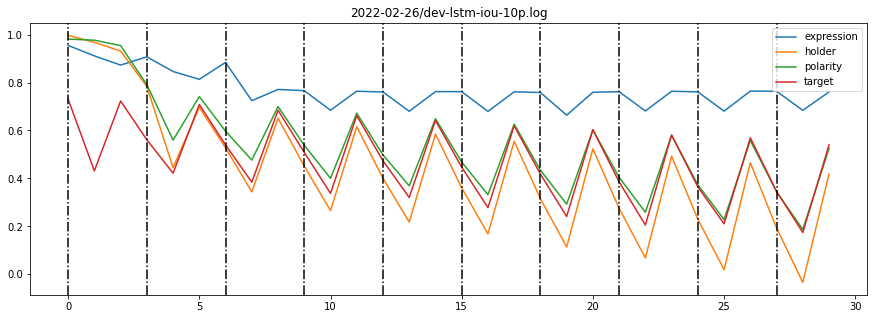

In [21]:
show_taskwise_loss("2022-02-26/dev-lstm-iou-10p.log")

# Frostbert

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
expression,1.098449,1.087328,1.062851,1.048240,1.038712,1.063060,1.049401,1.017100,1.042706,1.033403,...,0.895398,0.933446,0.783542,0.714142,0.916678,0.871008,0.839343,0.737734,0.774818,0.775970
holder,1.090456,1.053124,1.004231,0.955804,0.918971,0.886464,0.859237,0.807573,0.777901,0.740209,...,0.104223,0.087200,0.024501,0.030043,0.151560,0.101766,0.055423,0.017058,0.055590,0.042375
polarity,1.073668,1.024104,0.958981,0.849483,0.714881,0.632721,0.496769,0.446104,0.355111,0.432883,...,0.269946,0.209831,0.159693,0.137146,0.229229,0.182001,0.177037,0.287453,0.164730,0.054247
target,1.115447,1.060448,0.992333,0.887394,0.755675,0.662362,0.522224,0.457601,0.364913,0.433537,...,0.273538,0.230360,0.145719,0.150428,0.252247,0.170948,0.192289,0.276471,0.186354,0.056201


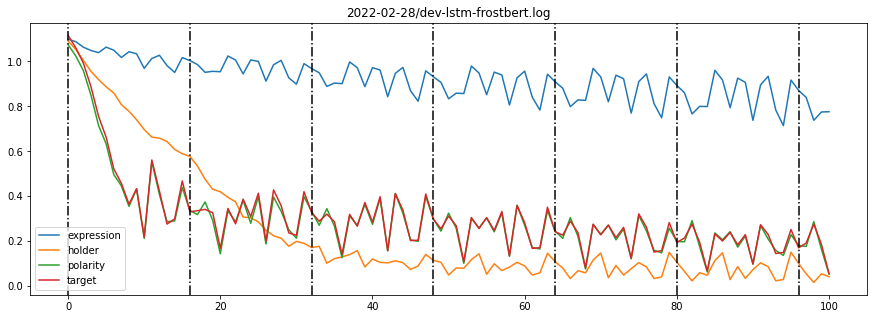

In [22]:
show_taskwise_loss("2022-02-28/dev-lstm-frostbert.log")

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
polarity,1.114068,1.061325,1.001557,0.919105,0.801609,0.694663,0.547880,0.473474,0.369600,0.440606,...,0.213592,0.168998,0.132262,0.304501,0.163656,0.056577,0.208346,0.156950,0.222850,0.173201
target,1.120665,1.066915,1.014767,0.936820,0.816906,0.715285,0.562154,0.474421,0.369324,0.434058,...,0.205981,0.152166,0.128869,0.314624,0.163122,0.055703,0.184747,0.127816,0.177106,0.167458


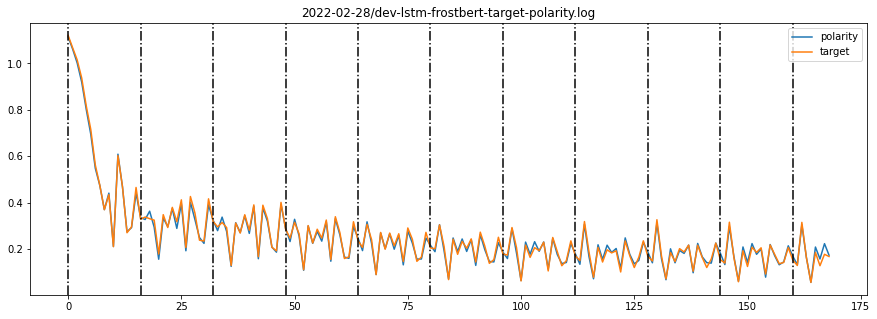

In [23]:
show_taskwise_loss("2022-02-28/dev-lstm-frostbert-target-polarity.log")

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
expression,1.099339,1.100345,1.101746,1.101866,1.101181,1.096696,1.097477,1.100632,1.097078,1.096657,...,1.092141,1.091775,1.091331,1.091438,1.089813,1.090917,1.090541,1.090529,1.090209,1.089388
holder,1.068936,1.067077,1.063799,1.061427,1.058957,1.055842,1.053551,1.048299,1.046115,1.043131,...,0.379981,0.324659,0.307524,0.344497,0.192138,0.244021,0.264173,0.279494,0.308202,0.179471
polarity,1.087163,1.078506,1.064094,1.052115,1.032251,1.019564,0.997318,0.975509,0.939356,0.897422,...,0.244757,0.401533,0.330843,0.298496,0.342135,0.290464,0.168196,0.326743,0.288236,0.368316
target,1.083204,1.073703,1.061684,1.047195,1.028061,1.015709,0.993558,0.971299,0.932539,0.885048,...,0.249501,0.418246,0.330116,0.312055,0.324171,0.312413,0.175653,0.331904,0.284005,0.369085


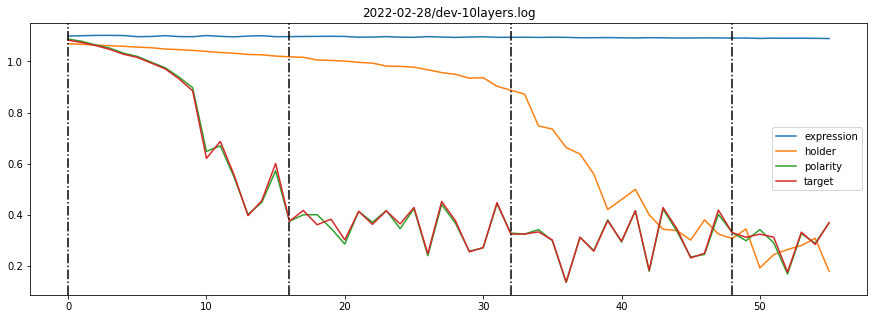

In [24]:
show_taskwise_loss("2022-02-28/dev-10layers.log")

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
polarity,1.081846,1.074591,1.065768,1.057749,1.045922,1.039985,1.030086,1.023022,1.014343,1.013183,...,0.997167,0.985825,0.969715,0.969627,0.967622,0.970978,0.942150,0.931873,0.929196,0.925595
target,1.104695,1.097805,1.089091,1.078642,1.065893,1.058934,1.047758,1.038148,1.029751,1.026554,...,1.007084,0.995875,0.978970,0.978815,0.974598,0.976052,0.947034,0.935507,0.930790,0.925311


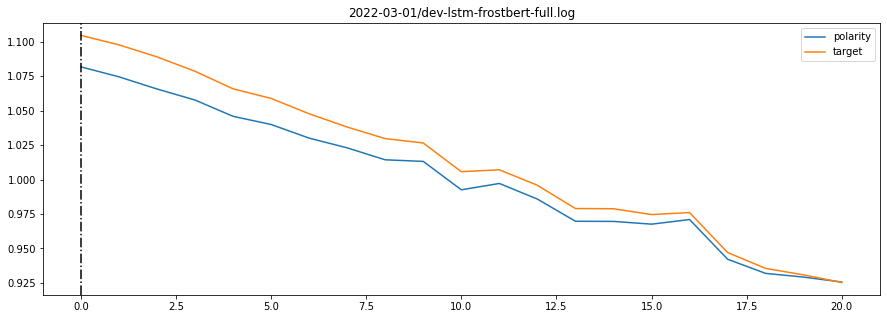

In [25]:
show_taskwise_loss("2022-03-01/dev-lstm-frostbert-full.log")

# 7 Layers

,0,1,2,3,4,5,6,7,8,9,...,950,951,952,953,954,955,956,957,958,959
polarity,1.093728,1.090733,1.087595,1.083684,1.078112,1.075846,1.070857,1.067703,1.062382,1.060623,...,0.266752,0.363966,0.284058,0.399256,0.177205,0.407541,0.325017,0.228627,0.234049,0.395645
target,1.109557,1.106496,1.102755,1.099482,1.095289,1.091256,1.086054,1.081534,1.076815,1.073380,...,0.259065,0.361648,0.293097,0.403620,0.184109,0.422613,0.342109,0.223070,0.240464,0.417691


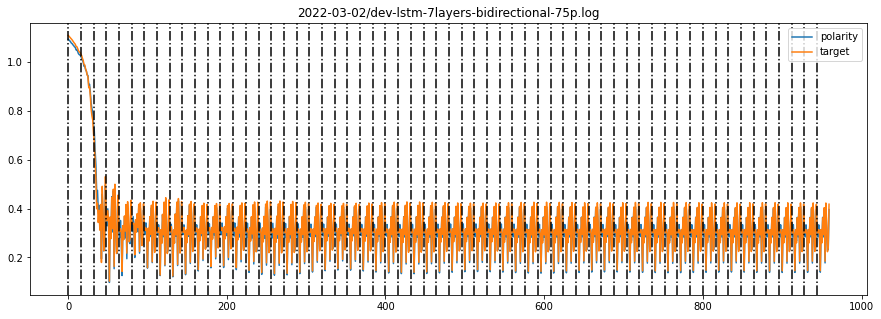

In [26]:
show_taskwise_loss("2022-03-02/dev-lstm-7layers-bidirectional-75p.log")

,0,1,2,3,4,5,6,7,8,9,...,950,951,952,953,954,955,956,957,958,959
polarity,1.099942,1.099489,1.097267,1.096616,1.094652,1.093295,1.091604,1.090606,1.089183,1.088527,...,0.272597,0.364724,0.285230,0.408920,0.177629,0.404533,0.324784,0.228045,0.231491,0.396005
target,1.084362,1.083289,1.081985,1.080428,1.077648,1.077904,1.075963,1.075398,1.073217,1.073765,...,0.266131,0.365662,0.295954,0.415643,0.183127,0.422889,0.342079,0.222714,0.238828,0.418878


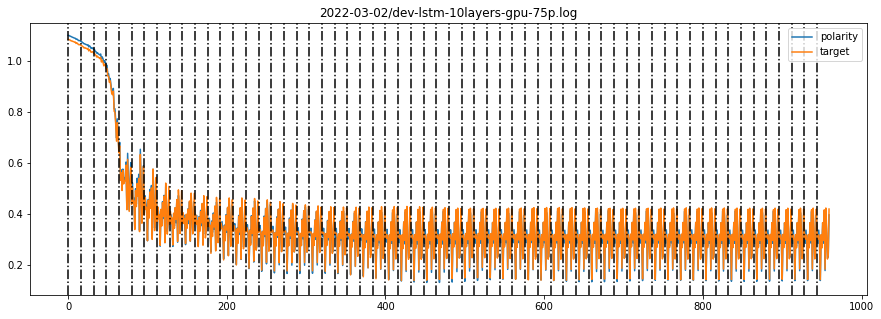

In [27]:
show_taskwise_loss("2022-03-02/dev-lstm-10layers-gpu-75p.log")

,0,1,2,3,4,5,6,7,8,9,...,950,951,952,953,954,955,956,957,958,959
polarity,1.099942,1.099489,1.097267,1.096616,1.094652,1.093295,1.091604,1.090606,1.089183,1.088527,...,0.272597,0.364724,0.285230,0.408920,0.177629,0.404533,0.324784,0.228045,0.231491,0.396005
target,1.084362,1.083289,1.081985,1.080428,1.077648,1.077904,1.075963,1.075398,1.073217,1.073765,...,0.266131,0.365662,0.295954,0.415643,0.183127,0.422889,0.342079,0.222714,0.238828,0.418878


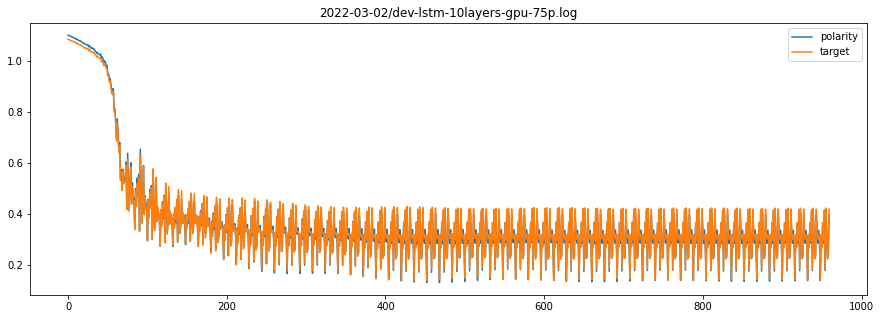

In [28]:
show_taskwise_loss("2022-03-02/dev-lstm-10layers-gpu-75p.log", get_epochs=False)

The three above plots were all using cross entropy loss. I think from here on, I'll abandon my loss exploration until I get a set up that eventually starts increasing Hard and ABSA above 0.

# IMN

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
expression,1.111952,1.042601,0.950483,0.868882,0.895292,0.753793,0.773774,0.857104,0.816725,0.931304,...,0.747780,0.928472,0.752995,0.846418,0.797683,0.775325,0.961167,0.904306,0.793056,0.765811
polarity,1.094944,0.972494,0.800225,0.663089,0.679204,0.617359,0.589089,0.641265,0.620823,0.615259,...,0.658775,0.651445,0.613460,0.644037,0.625316,0.611146,0.650056,0.672698,0.621915,0.632253
target,1.136132,0.992189,0.816550,0.676278,0.682606,0.618597,0.589437,0.641193,0.620796,0.615250,...,0.658775,0.651445,0.613460,0.644037,0.625316,0.611146,0.650056,0.672698,0.621915,0.632253


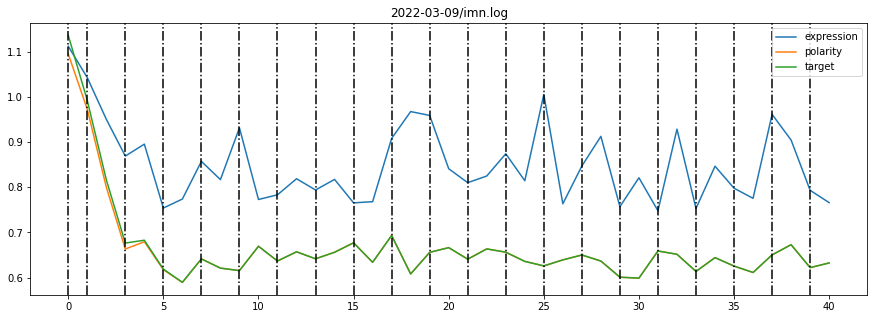

In [29]:
show_taskwise_loss("2022-03-09/imn.log")

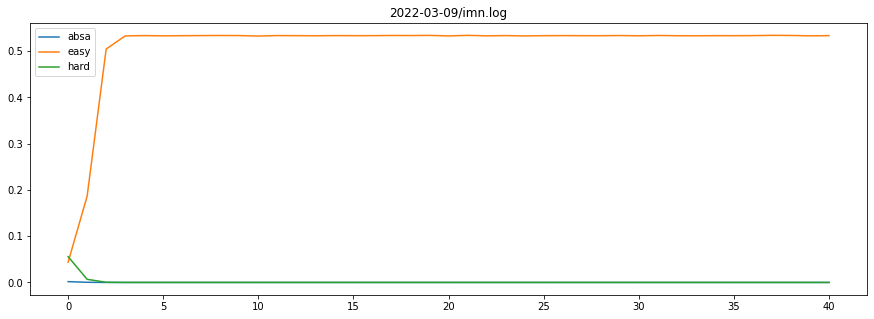

In [30]:
show_metrics("2022-03-09/imn.log")
None

## IMN learning rate 1e-9

In [31]:
def parse_loss(data):
    loss, _ = parse_taskwise_loss(data, get_epochs=False)
    return loss

In [32]:
def show_loss(name):
    return show_taskwise_loss(name, get_epochs=False)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
absa,0.001138,0.008152,0.000000,0.006040,0.000000,0.002939,0.013838,0.001667,0.000000,0.003881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hard,0.004054,0.006428,0.004310,0.007274,0.001187,0.004299,0.009894,0.006000,0.004806,0.005335,...,0.000000,0.000000,0.001984,0.003069,0.001113,0.000000,0.000000,0.000000,0.000000,0.000000
binary,0.520833,0.516204,0.535880,0.575231,0.527778,0.583333,0.561343,0.579861,0.560185,0.575231,...,0.716435,0.715278,0.666667,0.685185,0.670139,0.679398,0.694444,0.696759,0.728009,0.665509
proportional,0.048914,0.059791,0.055841,0.063271,0.057729,0.064433,0.052448,0.070093,0.059097,0.050084,...,0.273352,0.288618,0.277843,0.280559,0.242448,0.300235,0.292918,0.389908,0.324512,0.283842
span,0.249818,0.276639,0.289538,0.329707,0.285233,0.329931,0.350629,0.379708,0.360129,0.359443,...,0.763879,0.781501,0.715794,0.779189,0.745577,0.719545,0.773554,0.752596,0.787668,0.751214
macro,0.053971,0.063173,0.060332,0.067878,0.062740,0.074759,0.057524,0.076575,0.060482,0.051161,...,0.273524,0.289041,0.278515,0.279043,0.242958,0.301405,0.293622,0.388490,0.324101,0.285085


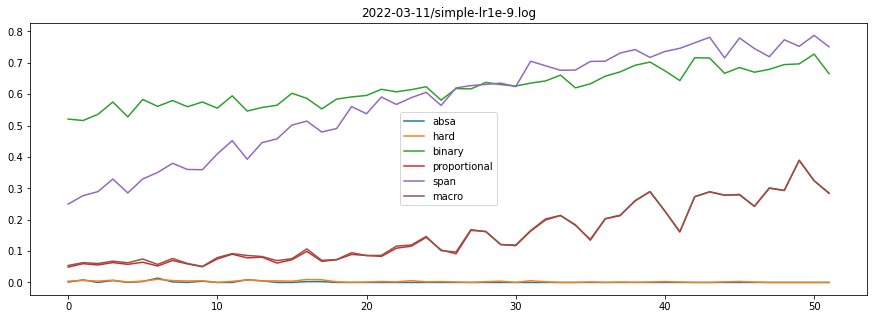

In [33]:
show_metrics("2022-03-11/simple-lr1e-9.log")

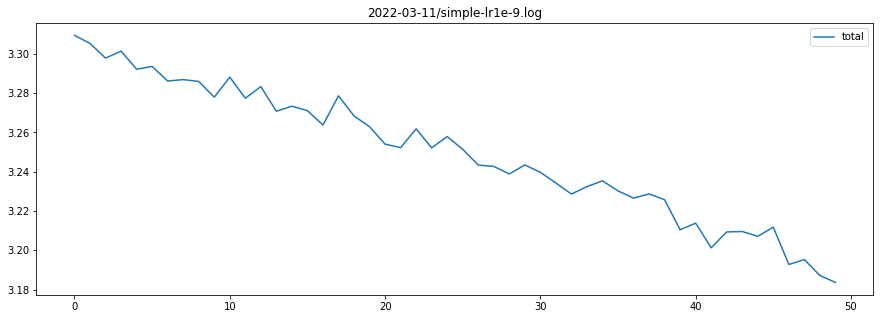

In [34]:
show_loss("2022-03-11/simple-lr1e-9.log")
None

In [35]:
my_s = "hello there strang alien!"

if 'here' in my_s:
    print(True)

True


# Study 
## Taskwise loss

In [36]:
def parse_large_logs(data):
    runs = []
    current_run = ["Parsing {} lines".format(len(data))]
    for line in data:
        if "new run" in line:
            runs.append(current_run)
            current_run = [line]
        else:
            current_run.append(line)
    runs.append(current_run)
    return runs

In [37]:
def get_runs(name):
    
    with open(name) as f:
        data = f.readlines()
        
    return parse_large_logs(data)

In [38]:
runs = get_runs("2022-03-11/dev-imn-scheduler.log")
len(runs)

4

In [39]:
def show_study_loss(name, title=None):
    runs = get_runs(name)[1:] # skip first "run"
    loss_dfs = {}
    metrics_dfs = {}
    
    for i, run in enumerate(runs):
        loss = parse_loss(run)
        metrics = parse_metrics(run)
        
        try:
            loss_df = show_data(loss, "Loss:{}".format(title if title is not None else name))
            metrics_df = show_data(metrics, "Metrics:{}".format(title if title is not None else name))
            plt.show()
            
            loss_dfs[i] = loss_df.T
            metrics_dfs[i] = metrics_df.T
            
            for row in run:
                if "Current" in row:
                    print("Above plots w/ following params:\n {}".format(row.split("Current params:")[-1]))
        
        except TypeError:
            print("No data for run {}".format(i))
    
    return loss_dfs, metrics_dfs

## Scheduler

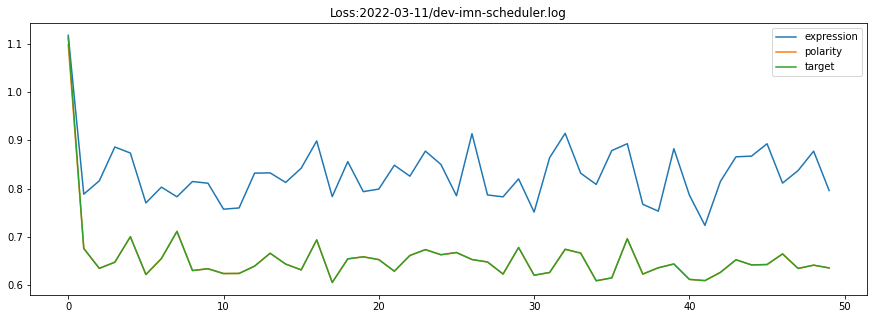

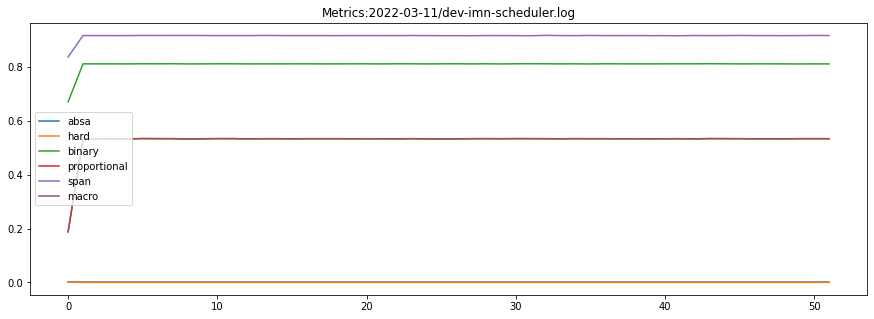

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'cnn_dim': 768, 'dropout': 0.1, 'lr_scheduler_patience': 5, 'shared_layers': 2, 'target_layers': 2, 'polarity_layers': 1, 'expression_layers': 2, 'interactions': 2, 'lr': 1e-05} (study.py:207)



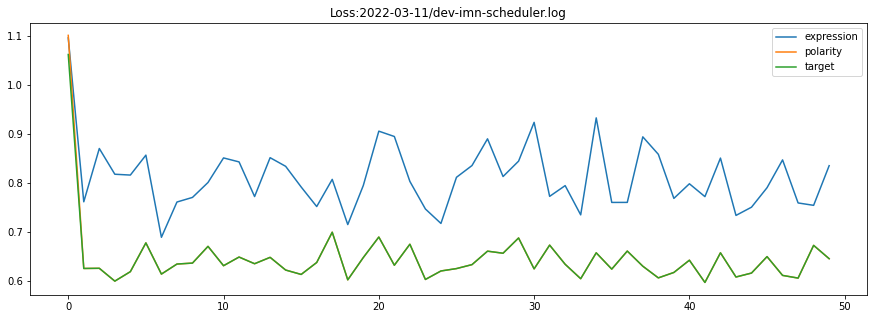

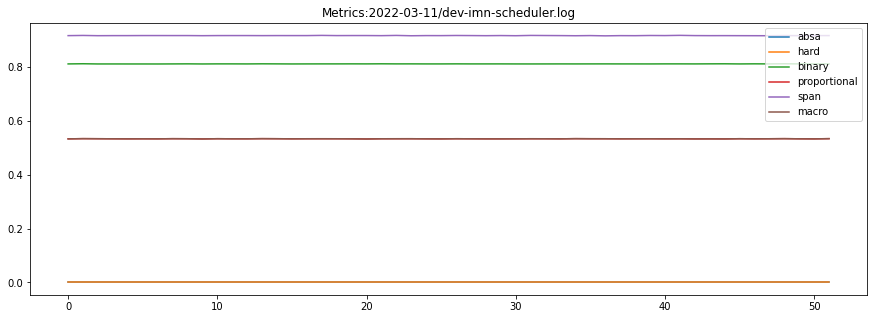

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'cnn_dim': 768, 'dropout': 0.1, 'lr_scheduler_patience': 5, 'shared_layers': 2, 'target_layers': 2, 'polarity_layers': 1, 'expression_layers': 2, 'interactions': 2, 'lr': 0.0001} (study.py:207)



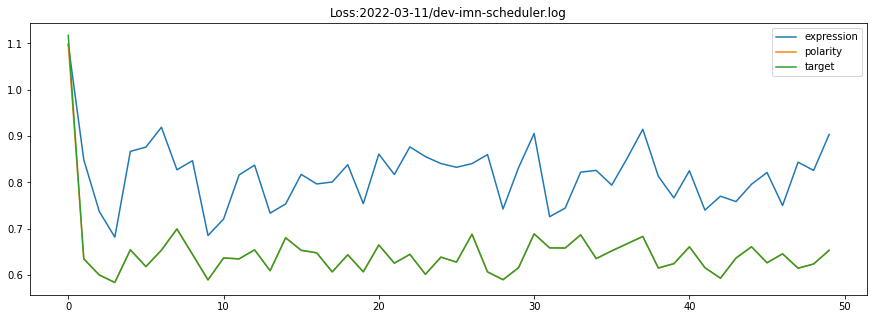

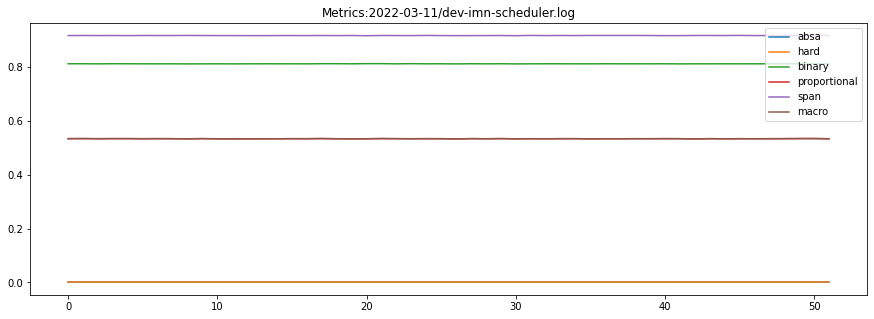

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'cnn_dim': 768, 'dropout': 0.1, 'lr_scheduler_patience': 5, 'shared_layers': 2, 'target_layers': 2, 'polarity_layers': 1, 'expression_layers': 2, 'interactions': 2, 'lr': 0.001} (study.py:207)



In [40]:
show_study_loss("2022-03-11/dev-imn-scheduler.log")
None

# Simple 

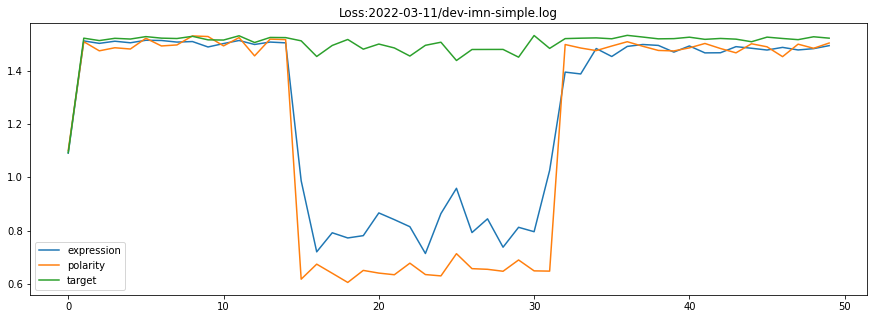

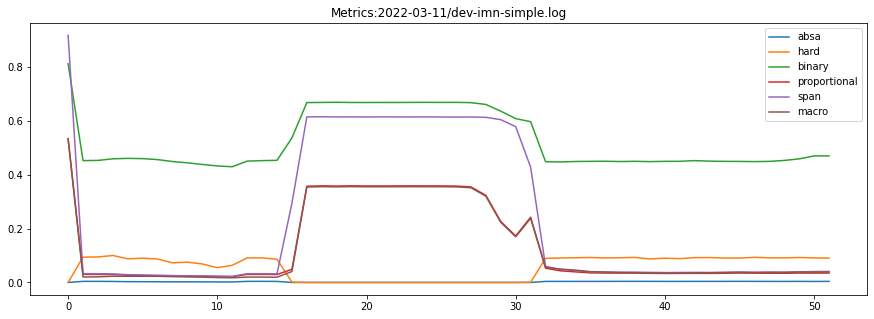

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'bert_finetune': True, 'cnn_dim': 768, 'dropout': 0.1, 'lr': 0.0001, 'shared_layers': 5, 'target_layers': 0, 'polarity_layers': 0, 'expression_layers': 0, 'interactions': 0} (study.py:207)



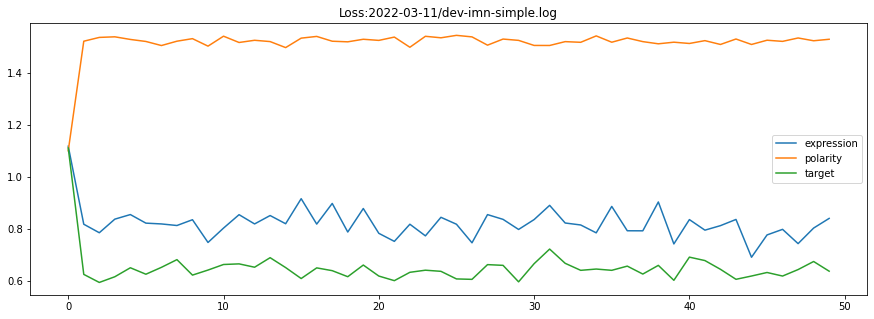

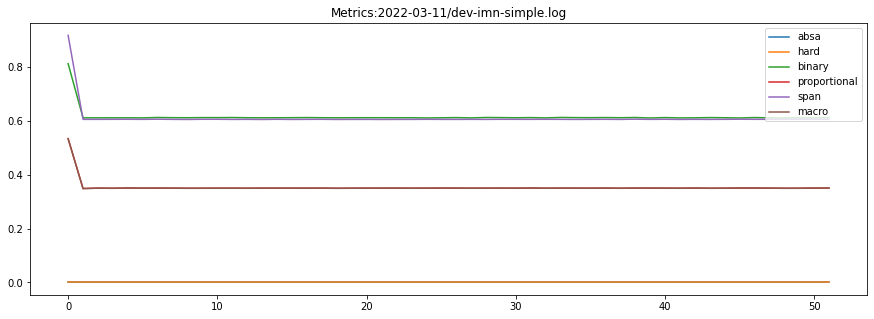

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'bert_finetune': True, 'cnn_dim': 768, 'dropout': 0.1, 'lr': 0.001, 'shared_layers': 5, 'target_layers': 0, 'polarity_layers': 0, 'expression_layers': 0, 'interactions': 0} (study.py:207)



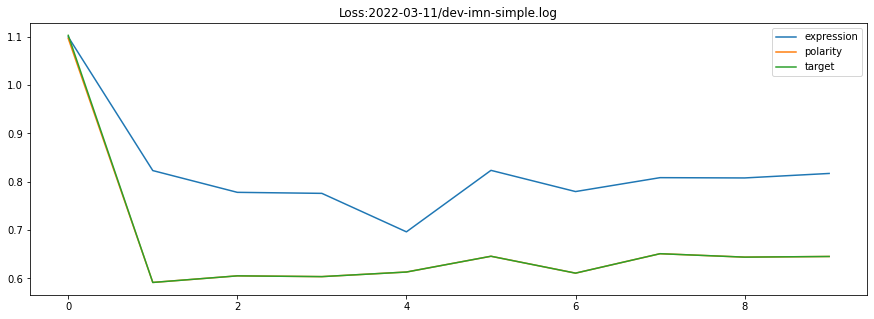

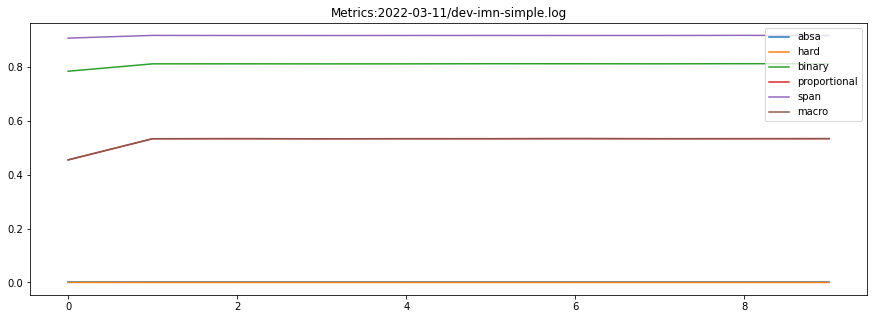

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'bert_finetune': True, 'cnn_dim': 768, 'dropout': 0.1, 'lr': 1e-05, 'shared_layers': 5, 'target_layers': 0, 'polarity_layers': 0, 'expression_layers': 0, 'interactions': 0} (study.py:207)

No data for run 3
No data for run 4
No data for run 5
No data for run 6


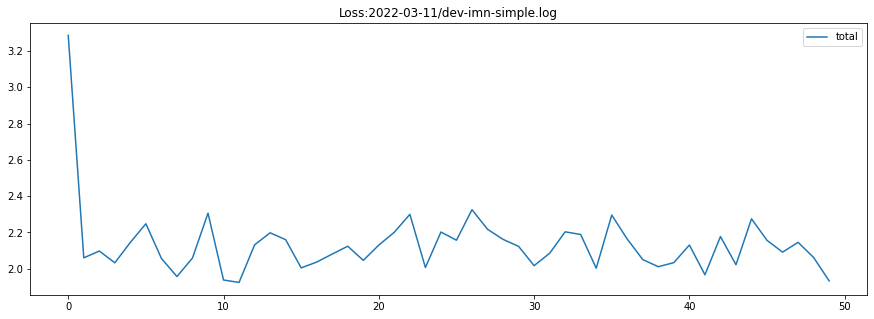

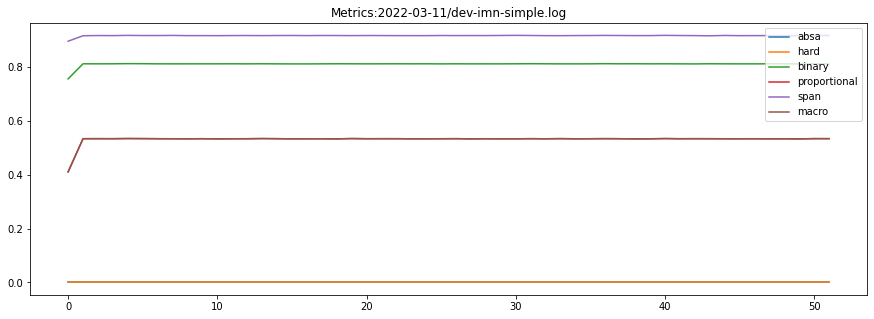

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'bert_finetune': True, 'cnn_dim': 768, 'dropout': 0.1, 'lr': 1e-05, 'shared_layers': 5, 'target_layers': 0, 'polarity_layers': 0, 'expression_layers': 0, 'interactions': 0} (study.py:207)

No data for run 8


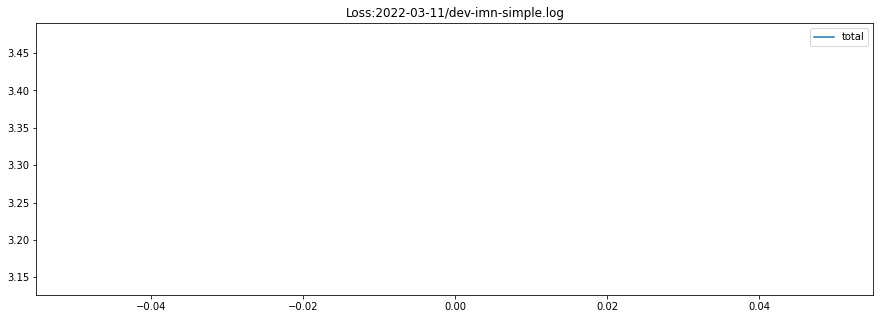

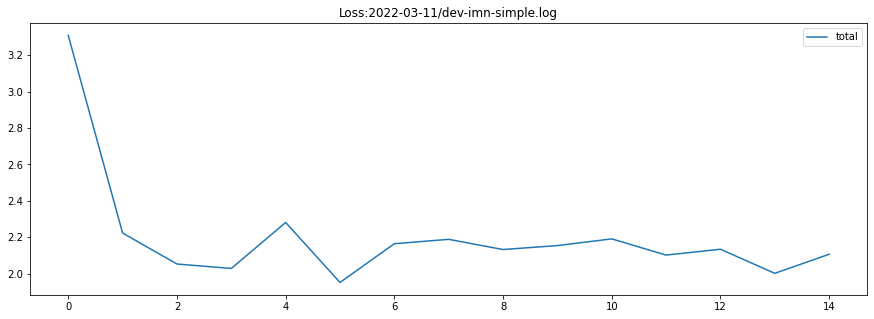

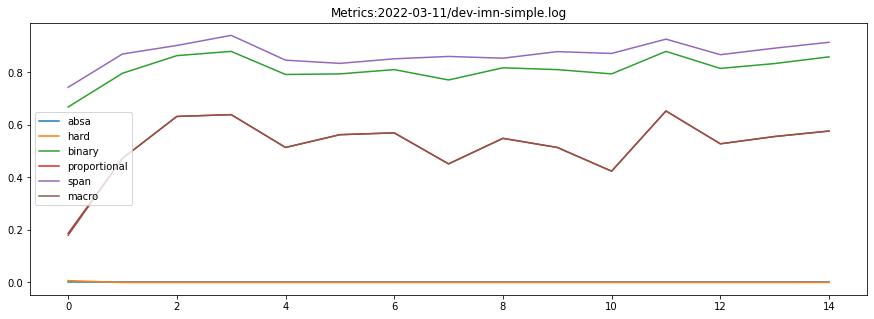

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'bert_finetune': True, 'cnn_dim': 768, 'dropout': 0.1, 'lr': 1e-05, 'shared_layers': 5, 'target_layers': 0, 'polarity_layers': 0, 'expression_layers': 0, 'interactions': 0} (study.py:207)



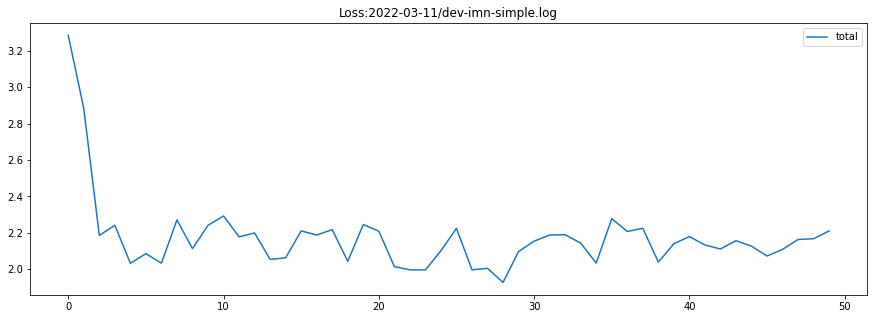

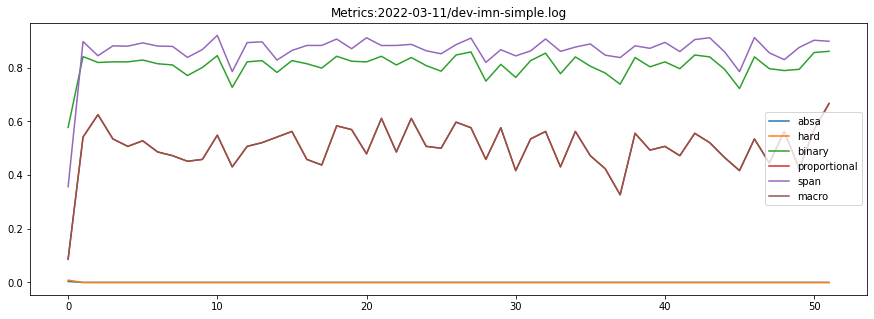

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'bert_finetune': True, 'cnn_dim': 768, 'dropout': 0.1, 'lr': 1e-07, 'lr_scheduler_patience': 10, 'shared_layers': 5, 'target_layers': 0, 'polarity_layers': 0, 'expression_layers': 0, 'interactions': 0} (study.py:207)



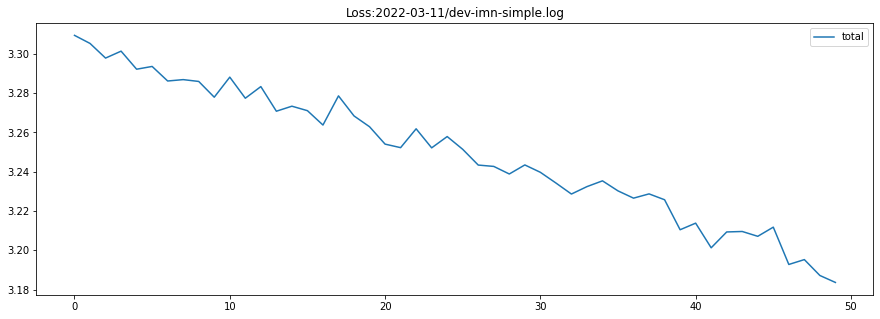

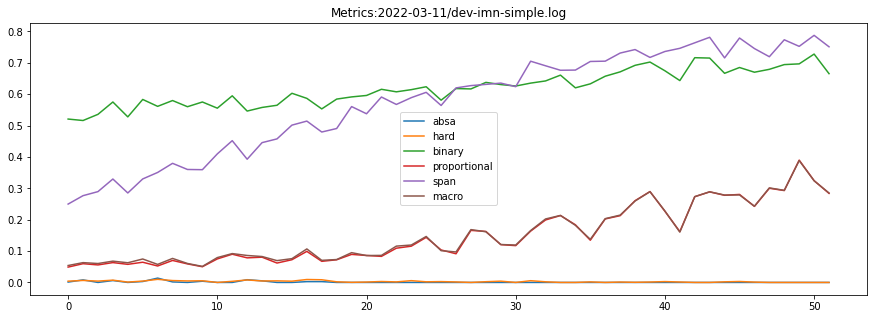

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 50, 'ignore_id': -1, 'bert_finetune': True, 'cnn_dim': 768, 'dropout': 0.1, 'lr': 1e-09, 'lr_scheduler_patience': 25, 'shared_layers': 5, 'target_layers': 2, 'polarity_layers': 2, 'expression_layers': 2, 'interactions': 2} (study.py:207)



In [47]:
show_study_loss("2022-03-11/dev-imn-simple.log")
None

# Span

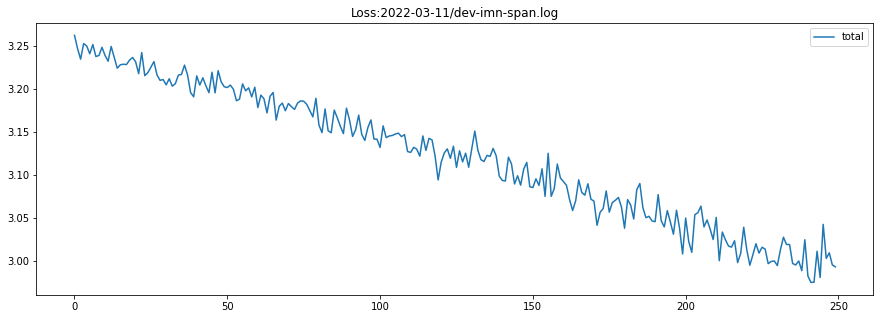

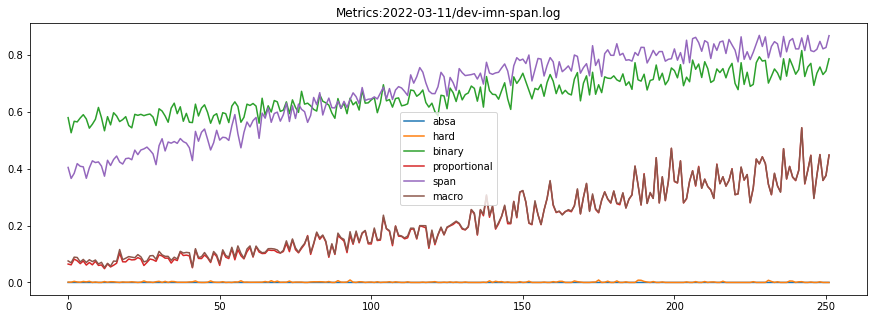

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 250, 'ignore_id': -1, 'lr': 1e-09, 'dropout': 0.1, 'cnn_dim': 100, 'shared_layers': 1, 'target_layers': 1, 'polarity_layers': 1, 'expression_layers': 1, 'interactions': 2, 'bert_finetune': False} (study.py:207)



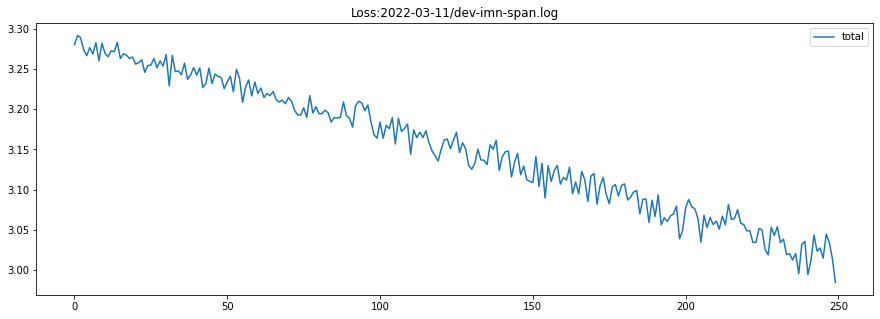

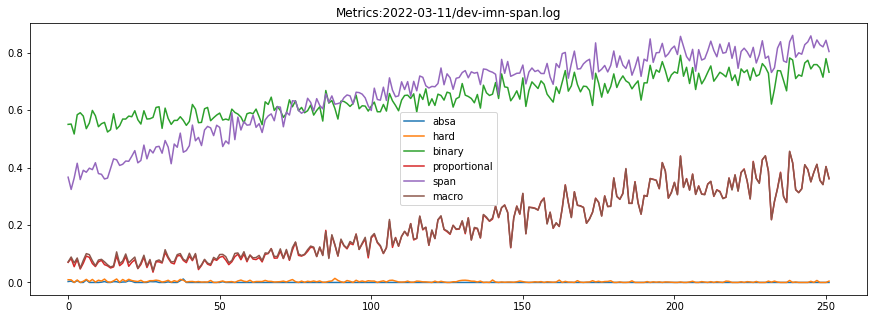

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 250, 'ignore_id': -1, 'lr': 1e-09, 'dropout': 0.1, 'cnn_dim': 100, 'shared_layers': 1, 'target_layers': 1, 'polarity_layers': 1, 'expression_layers': 1, 'interactions': 2, 'bert_finetune': True} (study.py:207)



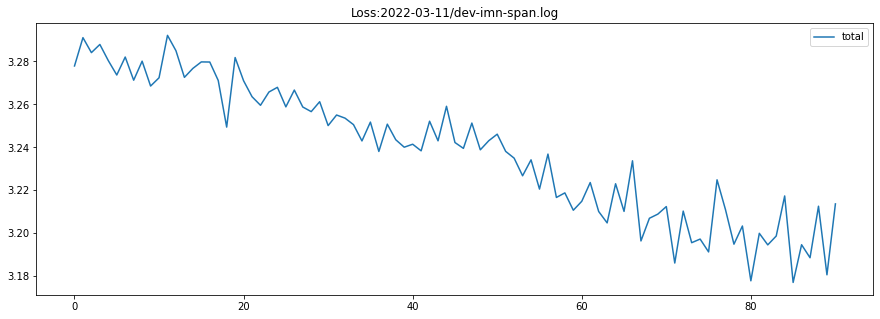

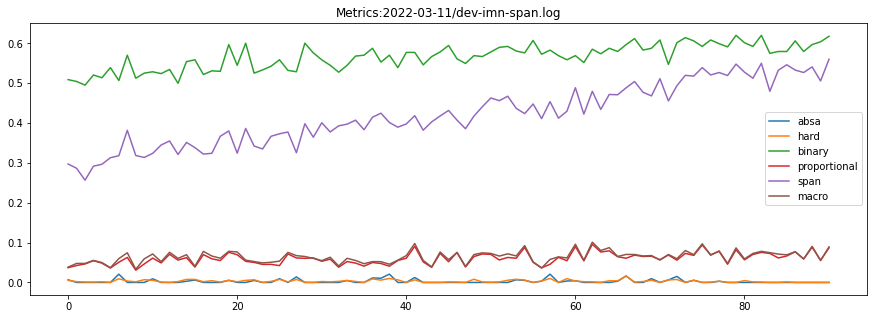

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 250, 'ignore_id': -1, 'lr': 1e-09, 'cnn_dim': 100, 'shared_layers': 1, 'target_layers': 1, 'polarity_layers': 1, 'expression_layers': 1, 'interactions': 2, 'bert_finetune': False, 'dropout': 0.1} (study.py:207)



In [48]:
show_study_loss("2022-03-11/dev-imn-span.log")
None

# SGD

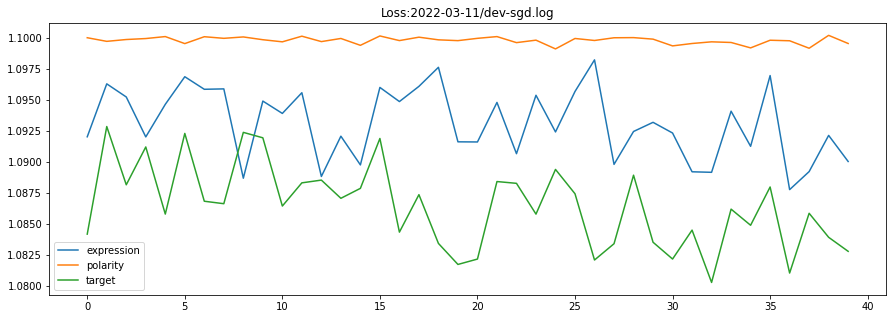

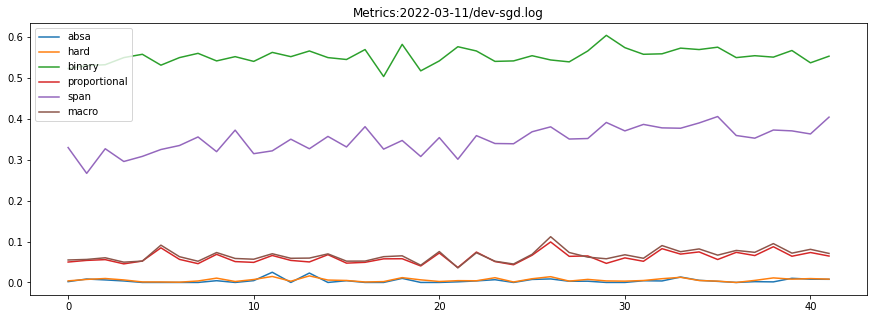

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 40, 'ignore_id': -1, 'optimizer_name': 'sgd', 'momentum': 0, 'nesterov': True, 'bert_finetune': True, 'lr': 1e-07, 'expression_lr': 1e-07, 'target_lr': 1e-07, 'polarity_lr': 1e-07, 'cnn_dim': 768, 'hidden_layers': 300, 'dropout': 0.1, 'lr_scheduler_patience': 25, 'shared_layers': 5, 'target_layers': 2, 'polarity_layers': 2, 'expression_layers': 2, 'interactions': 2} (study.py:218)



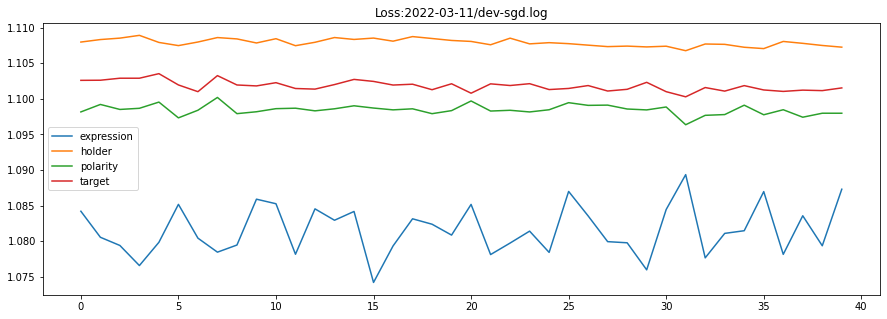

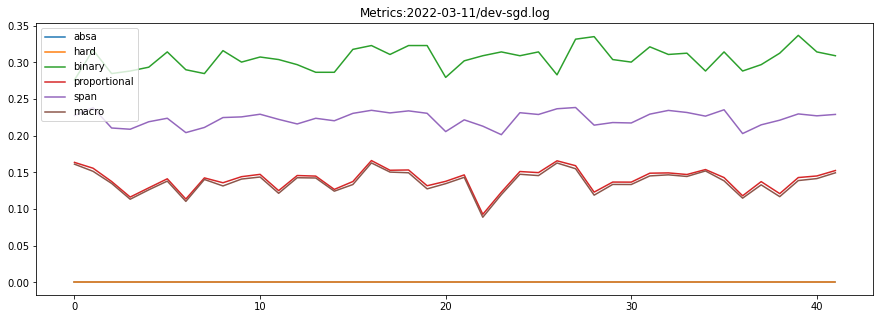

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 40, 'ignore_id': -1, 'optimizer_name': 'sgd', 'momentum': 0, 'nesterov': True, 'bert_finetune': True, 'lr': 1e-07, 'expression_lr': 1e-07, 'target_lr': 1e-07, 'polarity_lr': 1e-07, 'cnn_dim': 768, 'hidden_layers': 300, 'dropout': 0.1, 'lr_scheduler_patience': 25, 'shared_layers': 5, 'target_layers': 2, 'polarity_layers': 2, 'expression_layers': 2, 'interactions': 2} (study.py:218)



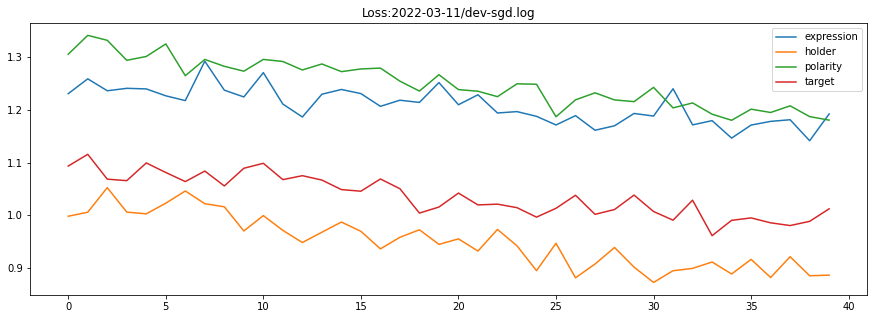

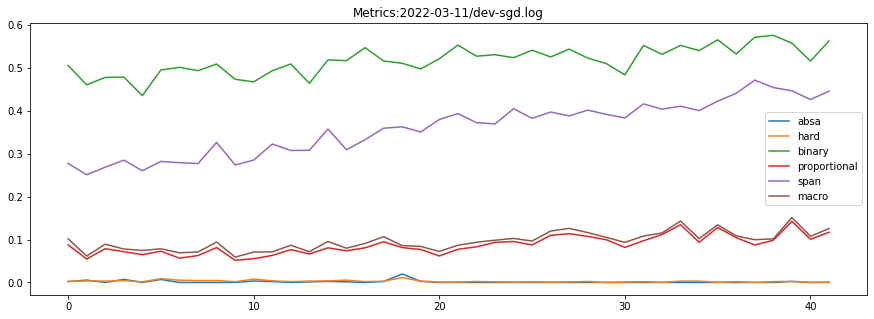

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 40, 'ignore_id': -1, 'optimizer_name': 'sgd', 'momentum': 0, 'nesterov': True, 'bert_finetune': True, 'lr': 1e-07, 'expression_lr': 1e-07, 'target_lr': 1e-07, 'polarity_lr': 1e-07, 'cnn_dim': 768, 'hidden_layers': 300, 'dropout': 0.1, 'lr_scheduler_patience': 25, 'shared_layers': 5, 'target_layers': 2, 'polarity_layers': 2, 'expression_layers': 2, 'interactions': 2} (study.py:218)



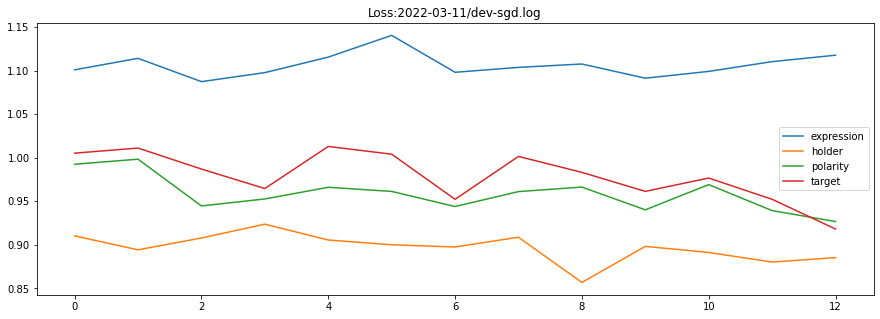

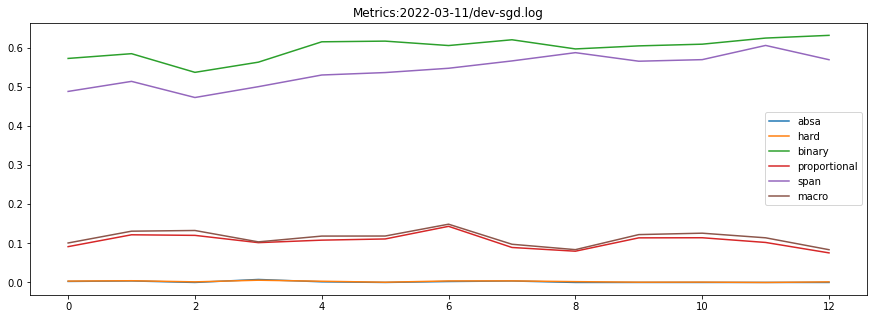

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 40, 'ignore_id': -1, 'optimizer_name': 'sgd', 'nesterov': True, 'bert_finetune': True, 'lr': 1e-07, 'expression_lr': 1e-07, 'target_lr': 1e-07, 'polarity_lr': 1e-07, 'cnn_dim': 768, 'hidden_layers': 300, 'dropout': 0.1, 'lr_scheduler_patience': 25, 'shared_layers': 5, 'target_layers': 2, 'polarity_layers': 2, 'expression_layers': 2, 'interactions': 2, 'momentum': 0} (study.py:218)



In [49]:
show_study_loss("2022-03-11/dev-sgd.log")
None

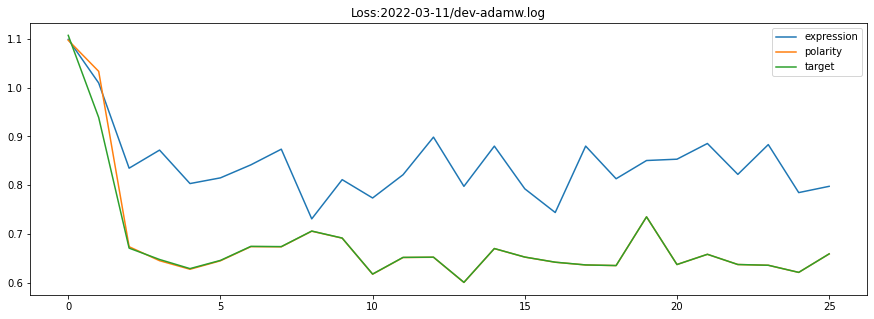

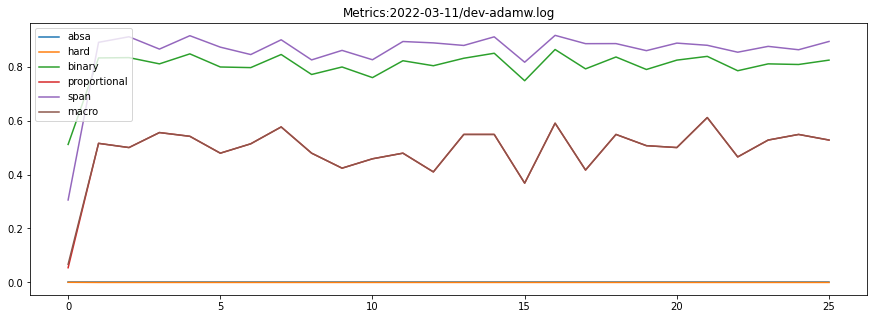

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 40, 'ignore_id': -1, 'optimizer_name': 'adamw', 'weight_decay': 0, 'amsgrad': True, 'bert_finetune': True, 'lr': 1e-07, 'expression_lr': 1e-07, 'target_lr': 1e-07, 'polarity_lr': 1e-07, 'cnn_dim': 768, 'hidden_layers': 300, 'dropout': 0.1, 'lr_scheduler_patience': 25, 'shared_layers': 5, 'target_layers': 2, 'polarity_layers': 2, 'expression_layers': 2, 'interactions': 2} (study.py:218)



In [45]:
show_study_loss("2022-03-11/dev-adamw.log")
None

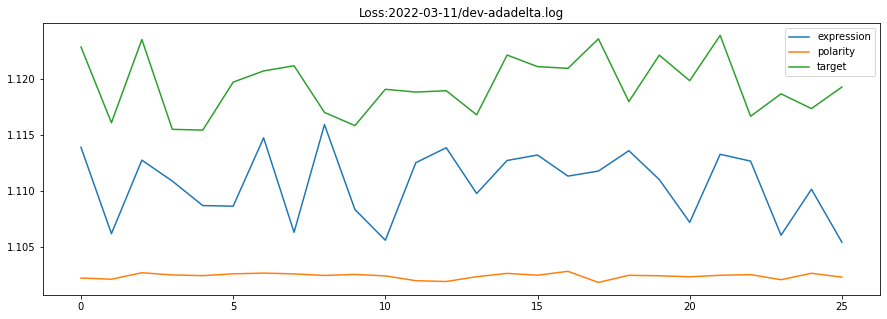

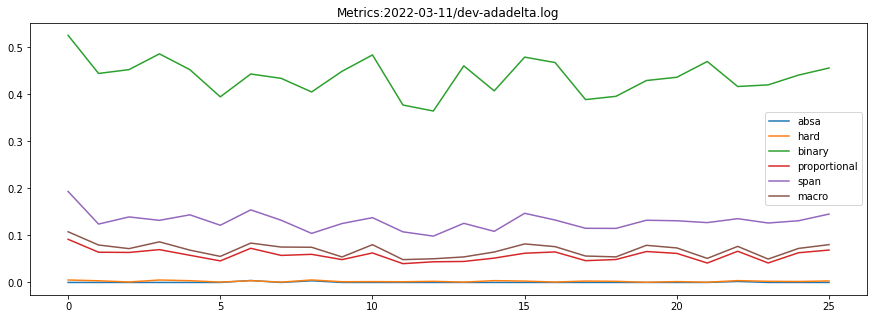

Above plots w/ following params:
  {'bert_path': 'ltgoslo/norbert', 'debug': False, 'device': 'cuda', 'epochs': 40, 'ignore_id': -1, 'optimizer_name': 'adadelta', 'weight_decay': 0, 'bert_finetune': True, 'lr': 1e-07, 'expression_lr': 1e-07, 'target_lr': 1e-07, 'polarity_lr': 1e-07, 'cnn_dim': 768, 'hidden_layers': 300, 'dropout': 0.1, 'lr_scheduler_patience': 25, 'shared_layers': 5, 'target_layers': 2, 'polarity_layers': 2, 'expression_layers': 2, 'interactions': 2} (study.py:218)



In [46]:
show_study_loss("2022-03-11/dev-adadelta.log")
None

# Confusion matrix
Won't have a confusion matrix, since only studying 1 parameter at a time. 

In [43]:
def get_study_results(data):
    results = []
    metric = None
    
    for row in data:
        if "Metric:" in row:
            metric = row.split("Metric:")[-1].split(' ')[0].strip()
            result = row.split("Score:")[-1].split(' ')[0].strip()
            if "=" in row:
                eq = row.split("=")
                param = eq[0].split('  ')[-1]
                value = eq[1].split(' ')[0]
            
            results.append(result)
            